In [1]:
# Environment setup and module import
from __future__ import print_function
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder


In [2]:
# Import DF from CSV

train_file = 'data/train_clean.csv'
#train_file = 'data/mini_train.csv'
train_df = pd.read_csv(train_file)


In [3]:
def reduce_mem(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train_df = reduce_mem(train_df)

Memory usage of dataframe is 7155.39 MB
Memory usage after optimization is: 1723.87 MB
Decreased by 75.9%


In [5]:
import gc
gc.collect()

20

In [6]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = [c for c,v in train_df.dtypes.items() if v in numerics and c in train_df.columns]
#numeric_cols

In [7]:
nominal_cols = [c for c in train_df.columns if (c not in numeric_cols)]
#nominal_cols

In [8]:
binary_cols = [c for c in train_df.columns if (train_df[c].nunique() == 2 and c not in nominal_cols)]
#binary_cols

In [9]:
#
# encode features with version numbers
#
def make_encoded_version_column(df, col):
    df[col] = df[col+'_major'] * 10000000 + df[col+'_minor'] * 100000 + df[col+'_build1'] * 1000 + df[col+'_build2']
    return df#.drop(columns=[col+'_major', col+'_minor',col+'_build1', col+'_build2'])

train_df = make_encoded_version_column(train_df, "EngineVersion")
train_df = make_encoded_version_column(train_df, "AppVersion")
train_df = make_encoded_version_column(train_df, "AvSigVersion")
train_df = make_encoded_version_column(train_df, "Census_OSVersion")

print("done encoding version columns")

done encoding version columns


In [10]:
#train_df['Census_OSVersion'].unique()
#train_df['AvSigVersion'].unique()
#train_df['EngineVersion'].unique()
train_df['AppVersion'].unique()



array([40404004])

IsBeta plot:


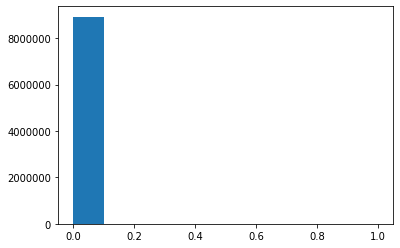

IsSxsPassiveMode plot:


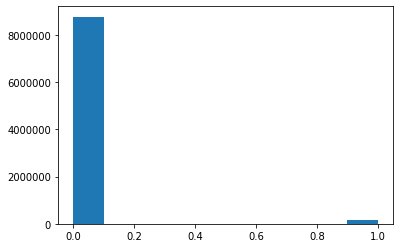

DefaultBrowsersIdentifier plot:


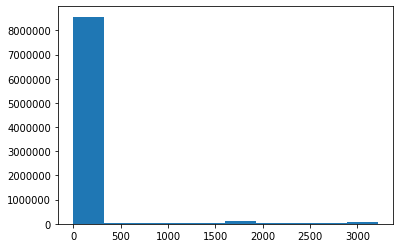

AVProductStatesIdentifier plot:


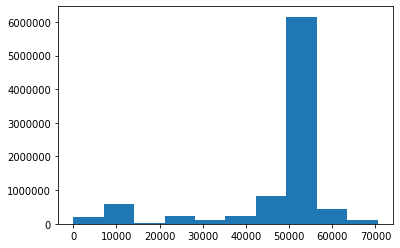

AVProductsInstalled plot:


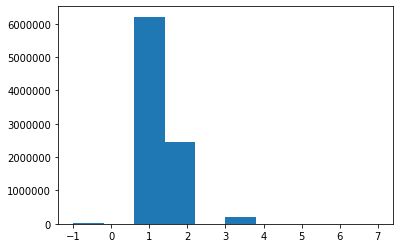

AVProductsEnabled plot:


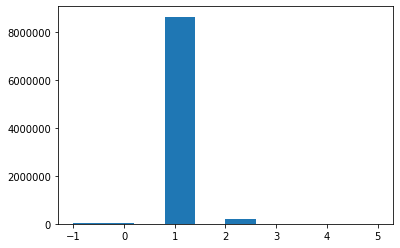

HasTpm plot:


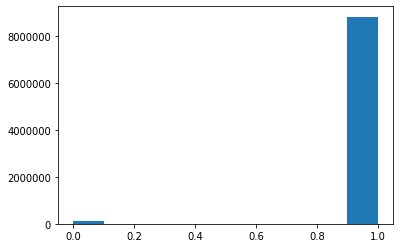

CountryIdentifier plot:


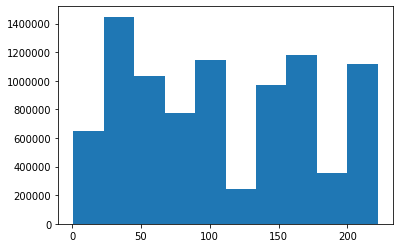

CityIdentifier plot:


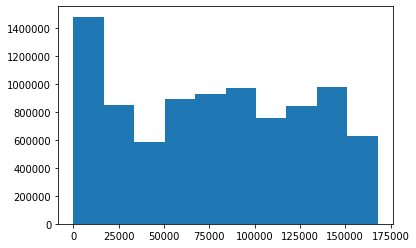

OrganizationIdentifier plot:


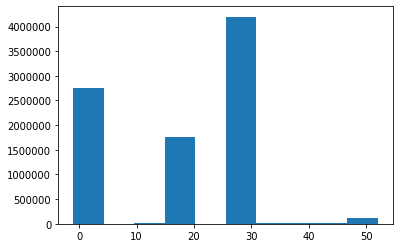

GeoNameIdentifier plot:


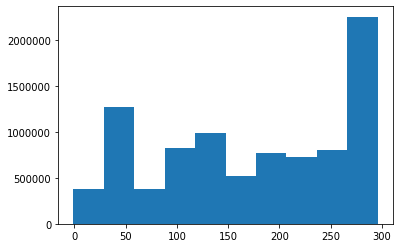

LocaleEnglishNameIdentifier plot:


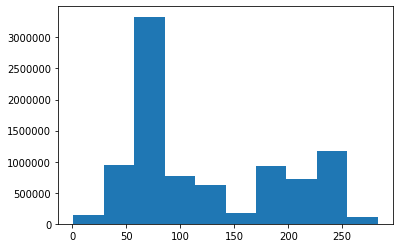

OsBuild plot:


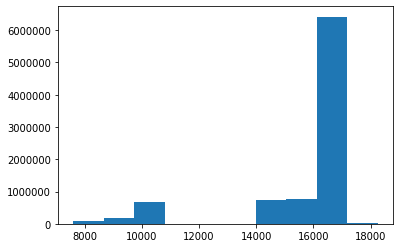

OsSuite plot:


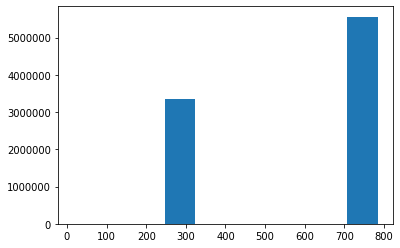

IsProtected plot:


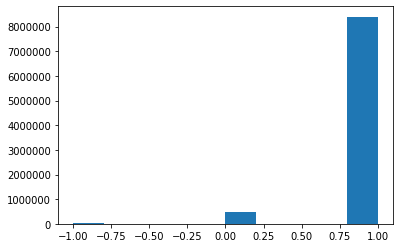

AutoSampleOptIn plot:


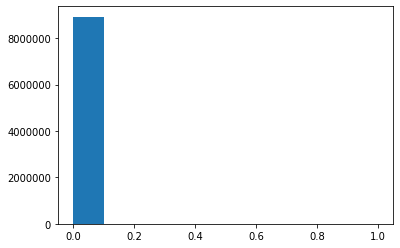

SMode plot:


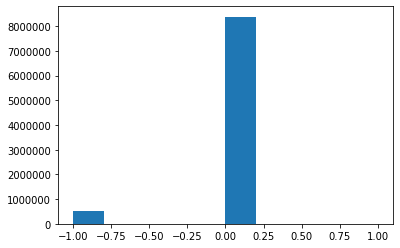

IeVerIdentifier plot:


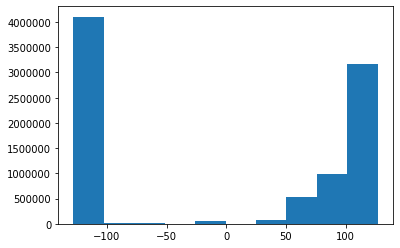

Firewall plot:


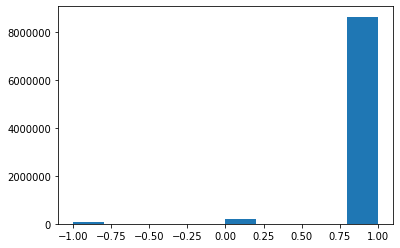

UacLuaenable plot:


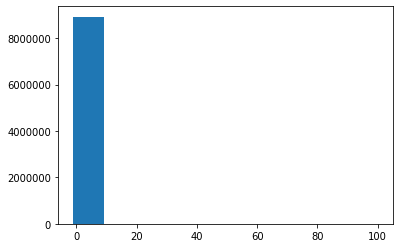

Census_OEMNameIdentifier plot:


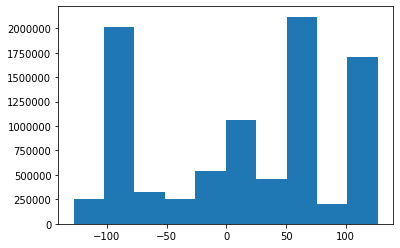

Census_OEMModelIdentifier plot:


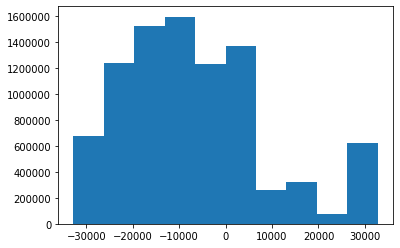

Census_ProcessorCoreCount plot:


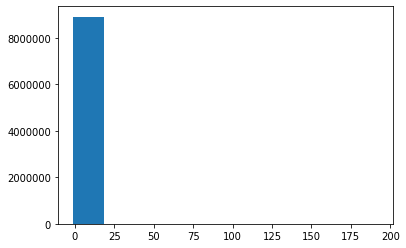

Census_ProcessorManufacturerIdentifier plot:


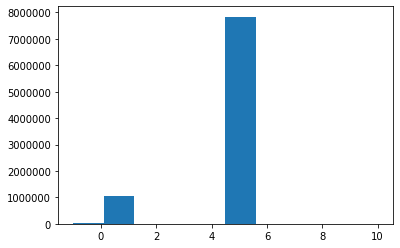

Census_ProcessorModelIdentifier plot:


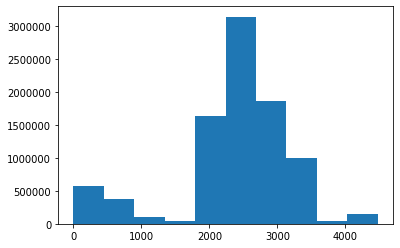

Census_PrimaryDiskTotalCapacity plot:


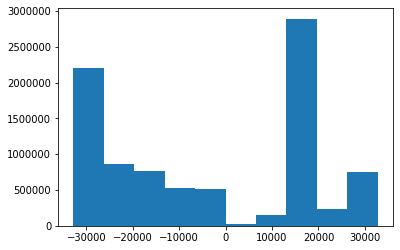

Census_SystemVolumeTotalCapacity plot:


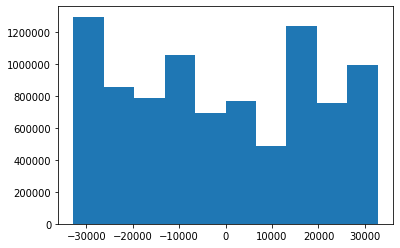

Census_HasOpticalDiskDrive plot:


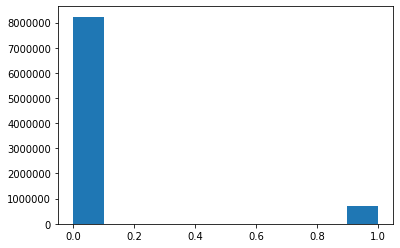

Census_TotalPhysicalRAM plot:


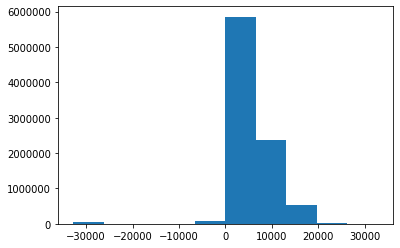

Census_InternalPrimaryDiagonalDisplaySizeInInches plot:


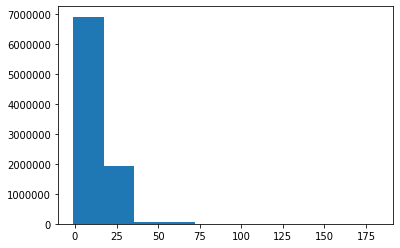

Census_InternalPrimaryDisplayResolutionHorizontal plot:


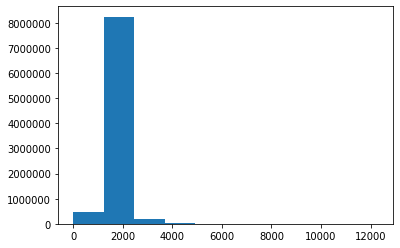

Census_InternalPrimaryDisplayResolutionVertical plot:


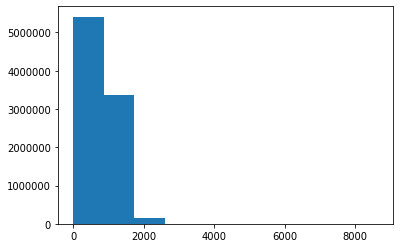

Census_InternalBatteryNumberOfCharges plot:


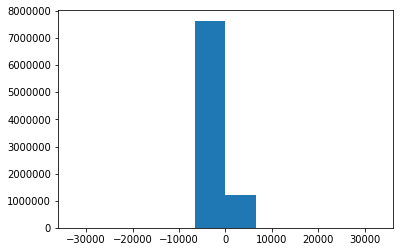

Census_OSBuildNumber plot:


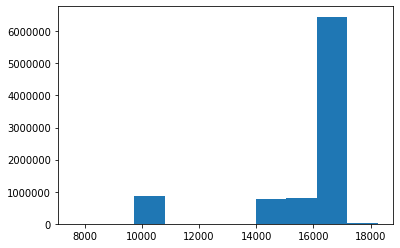

Census_OSBuildRevision plot:


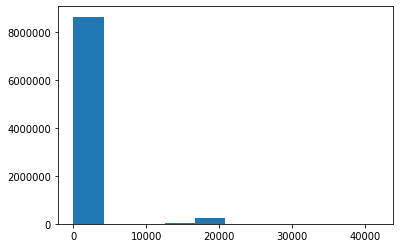

Census_OSInstallLanguageIdentifier plot:


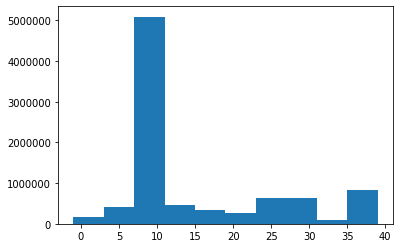

Census_OSUILocaleIdentifier plot:


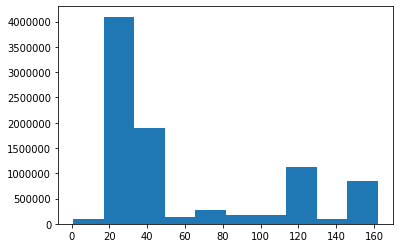

Census_IsPortableOperatingSystem plot:


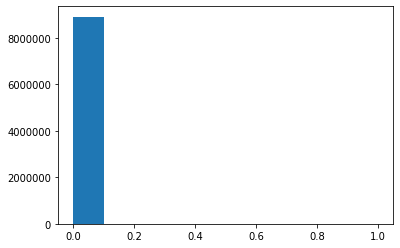

Census_IsFlightingInternal plot:


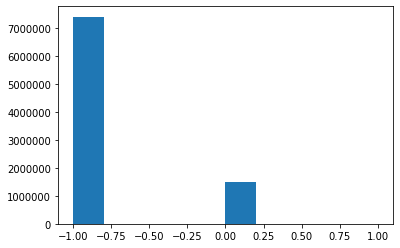

Census_IsFlightsDisabled plot:


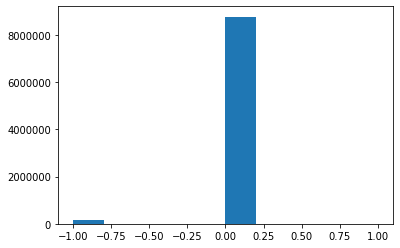

Census_ThresholdOptIn plot:


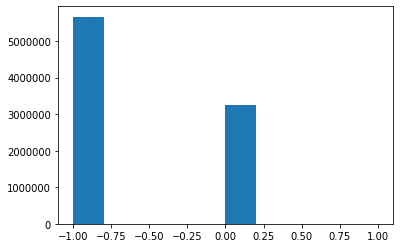

Census_FirmwareManufacturerIdentifier plot:


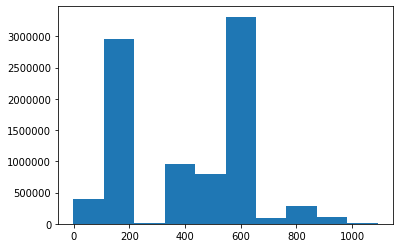

Census_FirmwareVersionIdentifier plot:


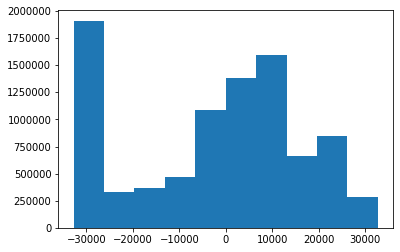

Census_IsSecureBootEnabled plot:


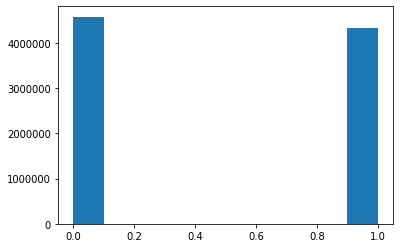

Census_IsWIMBootEnabled plot:


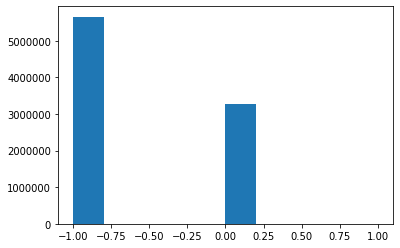

Census_IsVirtualDevice plot:


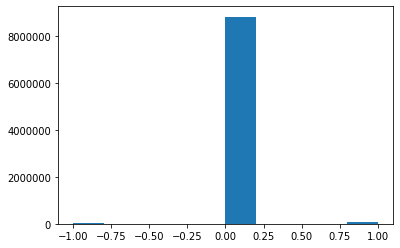

Census_IsTouchEnabled plot:


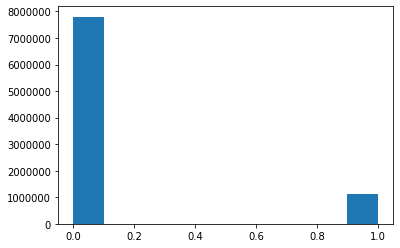

Census_IsPenCapable plot:


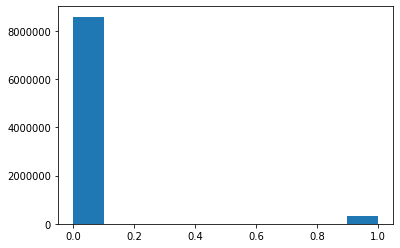

Census_IsAlwaysOnAlwaysConnectedCapable plot:


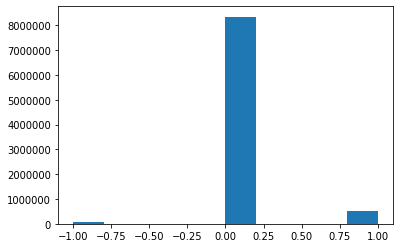

Wdft_IsGamer plot:


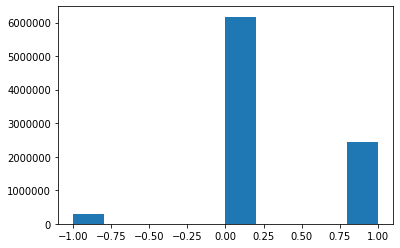

Wdft_RegionIdentifier plot:


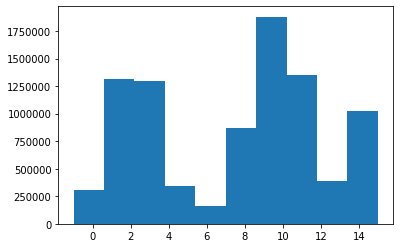

HasDetections plot:


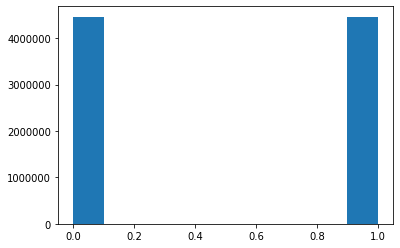

Rtp_NaN plot:


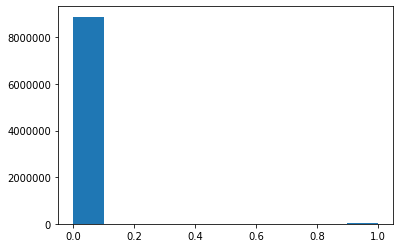

EngineVersion_major plot:


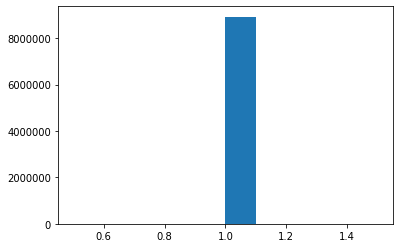

EngineVersion_minor plot:


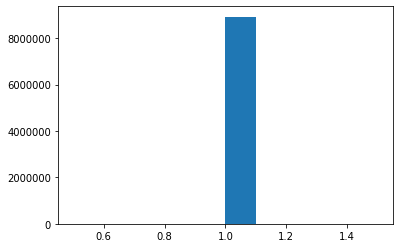

EngineVersion_build1 plot:


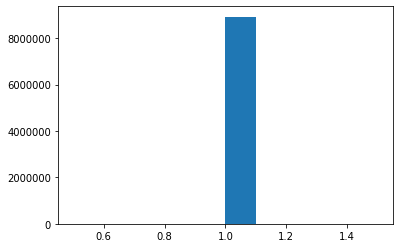

EngineVersion_build2 plot:


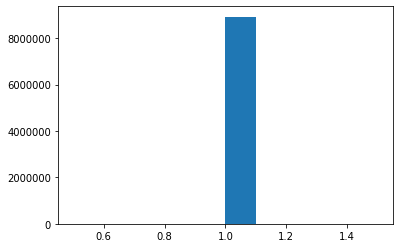

AppVersion_major plot:


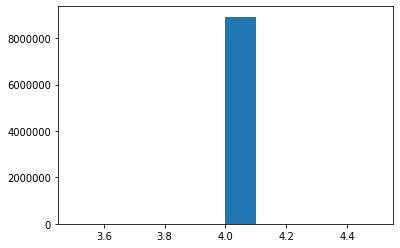

AppVersion_minor plot:


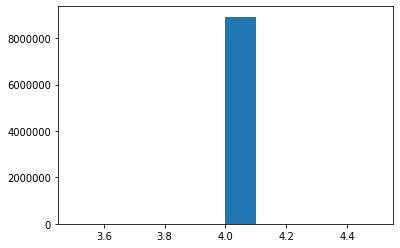

AppVersion_build1 plot:


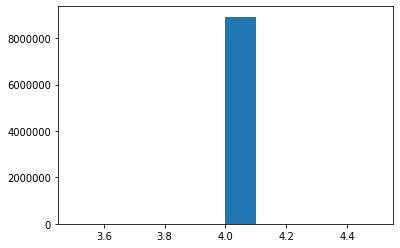

AppVersion_build2 plot:


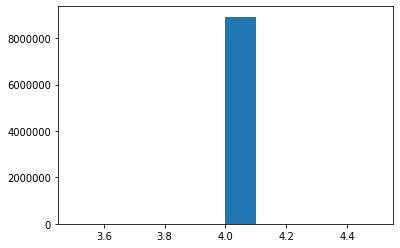

AvSigVersion_major plot:


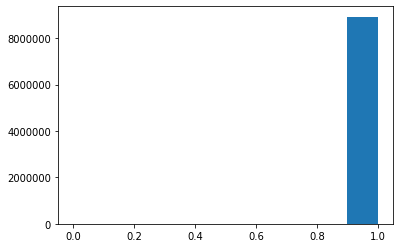

AvSigVersion_minor plot:


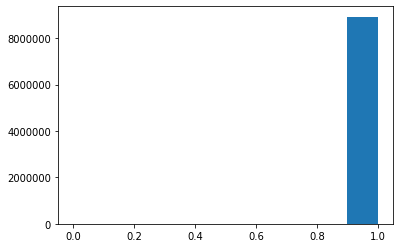

AvSigVersion_build1 plot:


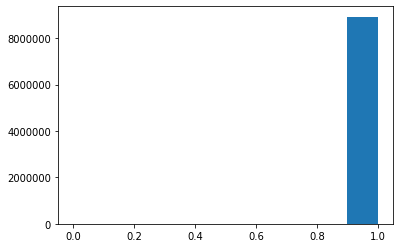

AvSigVersion_build2 plot:


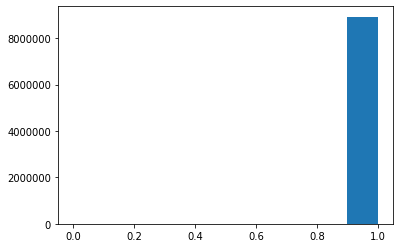

Census_OSVersion_major plot:


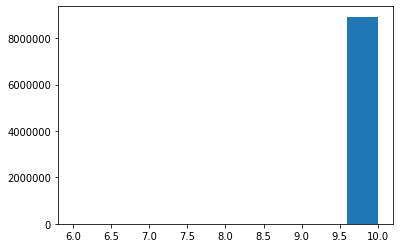

Census_OSVersion_minor plot:


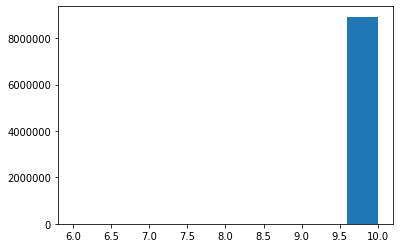

Census_OSVersion_build1 plot:


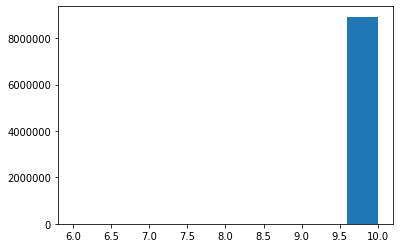

Census_OSVersion_build2 plot:


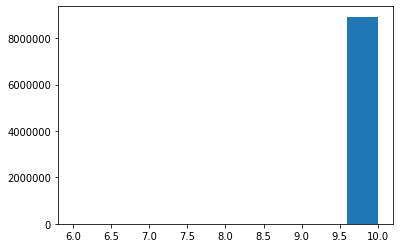

OsBuildLab_major plot:


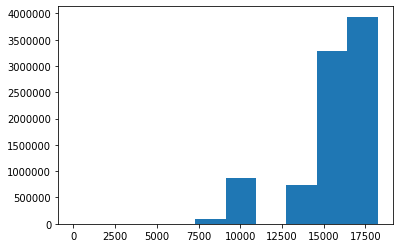

OsBuildLab_minor plot:


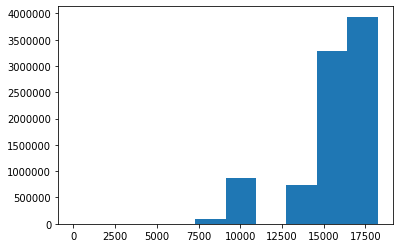

OsBuildLab_platform plot:


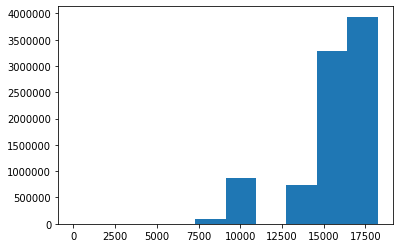

OsBuildLab_release plot:


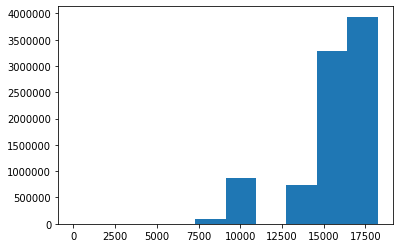

OsBuildLab_build1 plot:


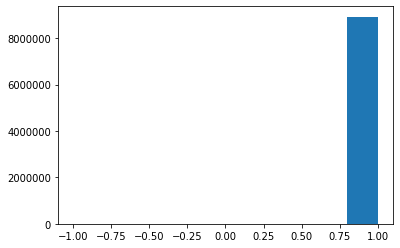

OsBuildLab_build2 plot:


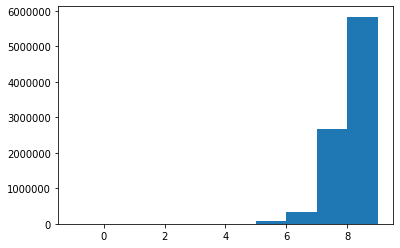

Rtp_0 plot:


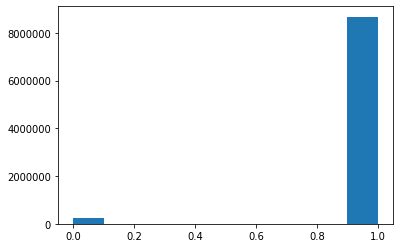

Rtp_1 plot:


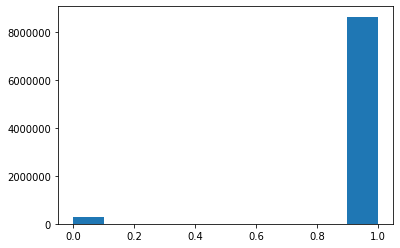

Rtp_2 plot:


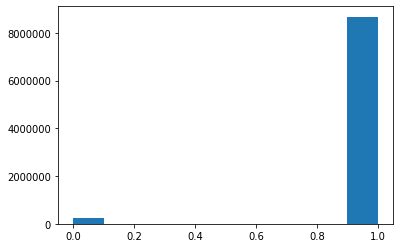

Rtp_3 plot:


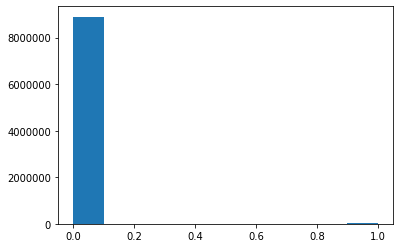

Rtp_4 plot:


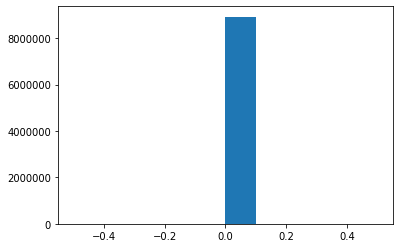

Rtp_5 plot:


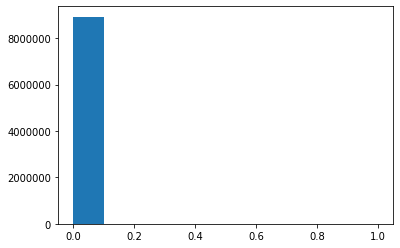

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
for n in numeric_cols:
    print(n,"plot:")
    plt.hist(train_df[n])
    plt.show()

In [12]:
# Encode nominal variables as labels
le = preprocessing.LabelEncoder()
train_df = train_df[nominal_cols].apply(le.fit_transform)
# train_df[nominal_cols].head()

In [13]:
# split out labels and ids
#train_labels = train_df["HasDetections"].values
#train_ids = train_df["MachineIdentifier"].values
#train_df = train_df.drop(columns=["HasDetections", "MachineIdentifier"])
for c in train_df.columns:
    print(train_df[c])

0                0
1                1
2                2
3                3
4                4
            ...   
8921478    8921478
8921479    8921479
8921480    8921480
8921481    8921481
8921482    8921482
Name: MachineIdentifier, Length: 8921483, dtype: int64
0          4
1          4
2          4
3          4
4          4
          ..
8921478    4
8921479    4
8921480    4
8921481    4
8921482    4
Name: ProductName, Length: 8921483, dtype: int64
0          0
1          0
2          0
3          0
4          0
          ..
8921478    0
8921479    0
8921480    0
8921481    0
8921482    0
Name: Platform, Length: 8921483, dtype: int64
0          1
1          1
2          1
3          1
4          1
          ..
8921478    1
8921479    2
8921480    1
8921481    1
8921482    1
Name: Processor, Length: 8921483, dtype: int64
0          0
1          0
2          0
3          0
4          0
          ..
8921478    0
8921479    0
8921480    0
8921481    0
8921482    0
Name: OsVer, Length: 8

In [14]:
# Perform whatever conversions are necessary to get everything into proper format: ndarray

le = preprocessing.LabelEncoder()
df = train_df[nominal_cols].apply(le.fit_transform)
for c in train_df.loc[:, train_df.dtypes == np.int8].columns:
    df[c] = train_df[c]
for c in train_df.loc[:, train_df.dtypes == np.int16].columns:
    df[c] = train_df[c]
for c in train_df.loc[:, train_df.dtypes == np.int32].columns:
    df[c] = train_df[c]
for c in train_df.loc[:, train_df.dtypes == np.float16].columns:
    df[c] = train_df[c]
for c in train_df[train_df.select_dtypes(bool).columns]:
    df[c] = train_df[c]

# To do: Perform standardization for input parameters


In [15]:
print(train_df.shape)
print(df.shape)

#
# encode the values of RtpStateBitfield (NaN, 0, 1, 3, 5, 7, 8, 35) as indicators
#

#df["Rtp_0"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&1 else 0).astype(np.uint8)
#df["Rtp_1"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&2 else 0).astype(np.uint8)
#df["Rtp_2"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&4 else 0).astype(np.uint8)
#df["Rtp_3"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&8 else 0).astype(np.uint8)
#df["Rtp_4"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&16 else 0).astype(np.uint8)
#df["Rtp_5"] = df["RtpStateBitfield"].map(lambda x: 0 if np.isnan(x) else 1 if int(x)&32 else 0).astype(np.uint8)
#df = df.drop(columns=["RtpStateBitfield"])
#print("done encoding RtpStateBitfield")

(8921483, 25)
(8921483, 25)


In [16]:

x_train = df
#y_train = train_labels


In [17]:
# Testing Cell
#print(x_train.shape)
#print(y_train.shape)

In [18]:
#
# save
#

train_file = 'data/train_encoded.csv'
#train_file = 'data/mini_train_encoded.csv'
#x_train.to_csv(train_file)

df.to_csv(train_file)
